# <span style="color:brown"> **Hands-on Deep Learning – Interpretability of Image Classification**

_This hands-on was created by Thomas Grenier, CREATIS_

thomas.grenier@creatis.insa-lyon.fr,
michael.sdika@creatis.insa-lyon.fr

# <span style="color:brown"> **Introduction on data**

This hands-on is computer scientist-oriented more than application-oriented. 

It is the second part of the classification hands-on: we will use the same data and study GradCam.
First cells are exactly the same as the first notebook.
Changes occur at section "E"

> Let's go!

# <span style="color:brown"> **A - Setup**

### A1 - First, import a few common modules, ensure MatplotLib plots figures inline, and functions for converting data and displaying reports:

In [1]:
# Common imports
import os
import glob

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

!pip install tqdm
from tqdm import tqdm

!pip install scikit-learn
from sklearn import datasets, metrics

# if trouble with libGL consider to execute this line in a shell: apt-get install python3-opencv
# and execute this line : !pip install opencv-python
import cv2

### A2- We import TensorFlow 2

In [2]:
import tensorflow as tf
print(tf.__version__)

2022-07-17 15:52:19.984587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


> _**if no error occurs, your working environment is ok and you can go to next part,
> else ... call an assistant for help!**_

# <span style="color:brown"> **B - Read the data**

<span style="color:red">
    

We first download the data and then deflate them.

In [3]:
#!rm dlss21_ho1_data.tar.gz
#!wget "https://gitlab.in2p3.fr/thomas.grenier/tp1ss_classification/-/raw/master/dlss21_ho1_data.tar.gz"
#!tar xzf dlss21_ho1_data.tar.gz

### <span style="color:brown"> **B1 - Open files and convert to numpy / tensorflow** 

> The next cells will open all images and create three datasets containing the images and the corresponding labels.


Some important values and initializations:

In [4]:
desired_height = 64
desired_width  = 64

input_train_path = os.getcwd()+'/dlss21_ho1_data/train'           
input_test_path = os.getcwd()+'/dlss21_ho1_data/test'            
print(f"input train path : {input_train_path}")
print(f"input test path  : {input_test_path}")

class_names = ['PD-A', 'PD-C', 'PD-S', 'T1-A', 'T1-C', 'T1-S', 'T2-A', 'T2-C', 'T2-S']

input_shape = (desired_height,desired_width,1)
input_shape_rgb = (desired_height,desired_width,3)
num_classes = 9

input train path : /home/jovyan/workspace/dlss21_ho1_data/train
input test path  : /home/jovyan/workspace/dlss21_ho1_data/test


In [5]:
# first list files for the train and validation sets.
train_val_image_file_list = []
train_val_label_list = []

for i in range(len(class_names)):
    for filename in glob.iglob( os.path.join(input_train_path,class_names[i]) + '/**/*.png', recursive=True):
        # extract patient number and slice
        train_val_image_file_list.append(filename)
        train_val_label_list.append( i )     

print(len(train_val_image_file_list), len(train_val_label_list))
print(train_val_image_file_list[0])

24418 24418
/home/jovyan/workspace/dlss21_ho1_data/train/PD-A/253_109_PD-A.png


In [6]:
# Random permutation
permutation = np.random.permutation( len(train_val_label_list) )
train_val_images_files=[train_val_image_file_list[i] for i in permutation]
train_val_labels=[train_val_label_list[i] for i in permutation]

In [7]:
# we split the train set in two parts : train and validation
VALIDATION_RATIO = 0.2
nb_train = int( len(train_val_label_list) * (1 - VALIDATION_RATIO) )
# list images for both datasets
train_images_files = train_val_images_files[:nb_train]
train_labels =train_val_labels[:nb_train]

val_images_files = train_val_images_files[nb_train:]
val_labels = train_val_labels[nb_train:]

# for labels also convert them to numpy
y_train = np.asarray(train_labels)
y_val = np.asarray(val_labels)

print( train_val_images_files[0])

/home/jovyan/workspace/dlss21_ho1_data/train/T1-A/462_65_T1-A.png


In [8]:
# Reading images 
def ReadImages(images_files):
    X = []
    for index in tqdm(range(len(images_files))):
        image_read = cv2.imread(images_files[index], cv2.IMREAD_COLOR)
        image_read = cv2.resize(image_read, dsize = (desired_width, desired_height), interpolation = cv2.INTER_LINEAR)
        X.append(image_read)
    X = np.asarray(X, dtype=np.uint8)
    return X

In [9]:
# Read images
X_train_rgb = ReadImages(train_images_files)
X_val_rgb = ReadImages(val_images_files)

100%|██████████| 4884/4884 [00:00<00:00, 12720.98it/s]


### <span style="color:brown"> **B2 - Check the output data size and type**
We recommend to check as often as needed the shape and type of data.

Don't go further if you can't see what is inside array and tensor!

In [10]:
# Show information
print(" Shape : " , X_train_rgb.shape, X_val_rgb.shape)
print(" Type  : %s  %s"%(X_train_rgb.dtype, X_val_rgb.dtype))
print(" Max   : %d  %d"%(X_train_rgb.max(), X_val_rgb.max()))
print(" Min   : %d  %d"%(X_train_rgb.min(), X_val_rgb.min()))

print(" Labels Shape : " , y_train.shape, y_val.shape)

 Shape :  (19534, 64, 64, 3) (4884, 64, 64, 3)
 Type  : uint8  uint8
 Max   : 255  255
 Min   : 0  0
 Labels Shape :  (19534,) (4884,)


### <span style="color:brown"> **B3 - Displaying images**

In [11]:
def plot_image(image):
    plt.imshow(image, aspect="equal", cmap="gray", interpolation="nearest")
    plt.axis("off")    

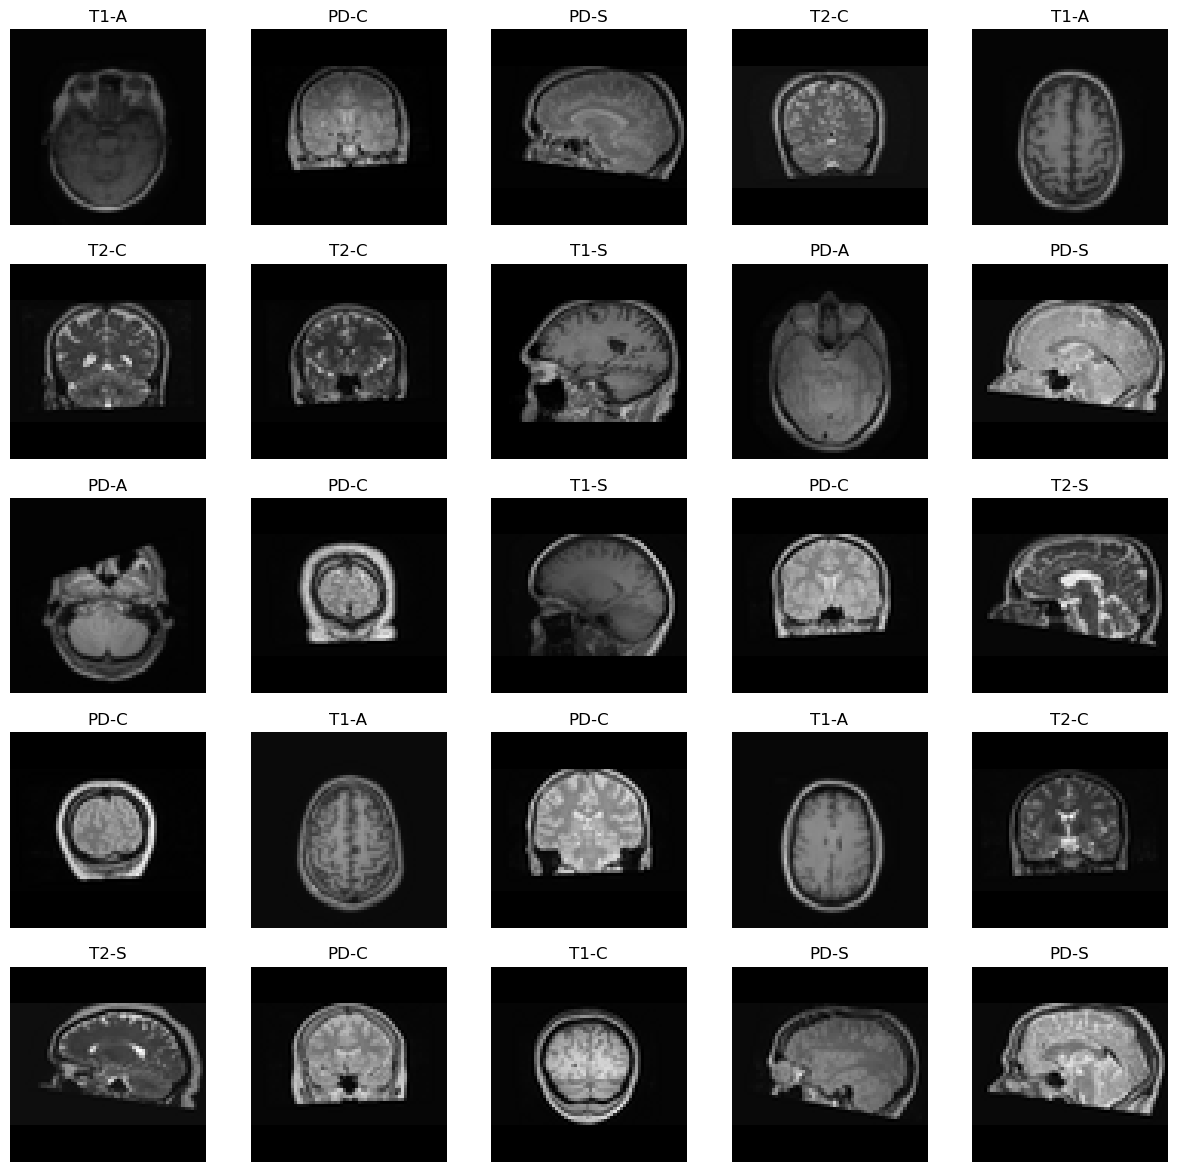

In [12]:
nb_x = 5
nb_y = 5
plt.figure(figsize=(15,15*nb_x/nb_y), dpi=100)
for i in range(1, nb_x * nb_y +1):
    plt.subplot(nb_x, nb_y ,i)
    plot_image( X_train_rgb[i-1] )
    plt.title(class_names[y_train[i-1]])

### <span style="color:brown"> **B4 - Test set**

6178 6178


100%|██████████| 6178/6178 [00:00<00:00, 13225.83it/s]


 Shape :  (6178, 64, 64, 3) (6178,)
 Type  : uint8  int64
 Max   : 255  8
 Min   : 0  0


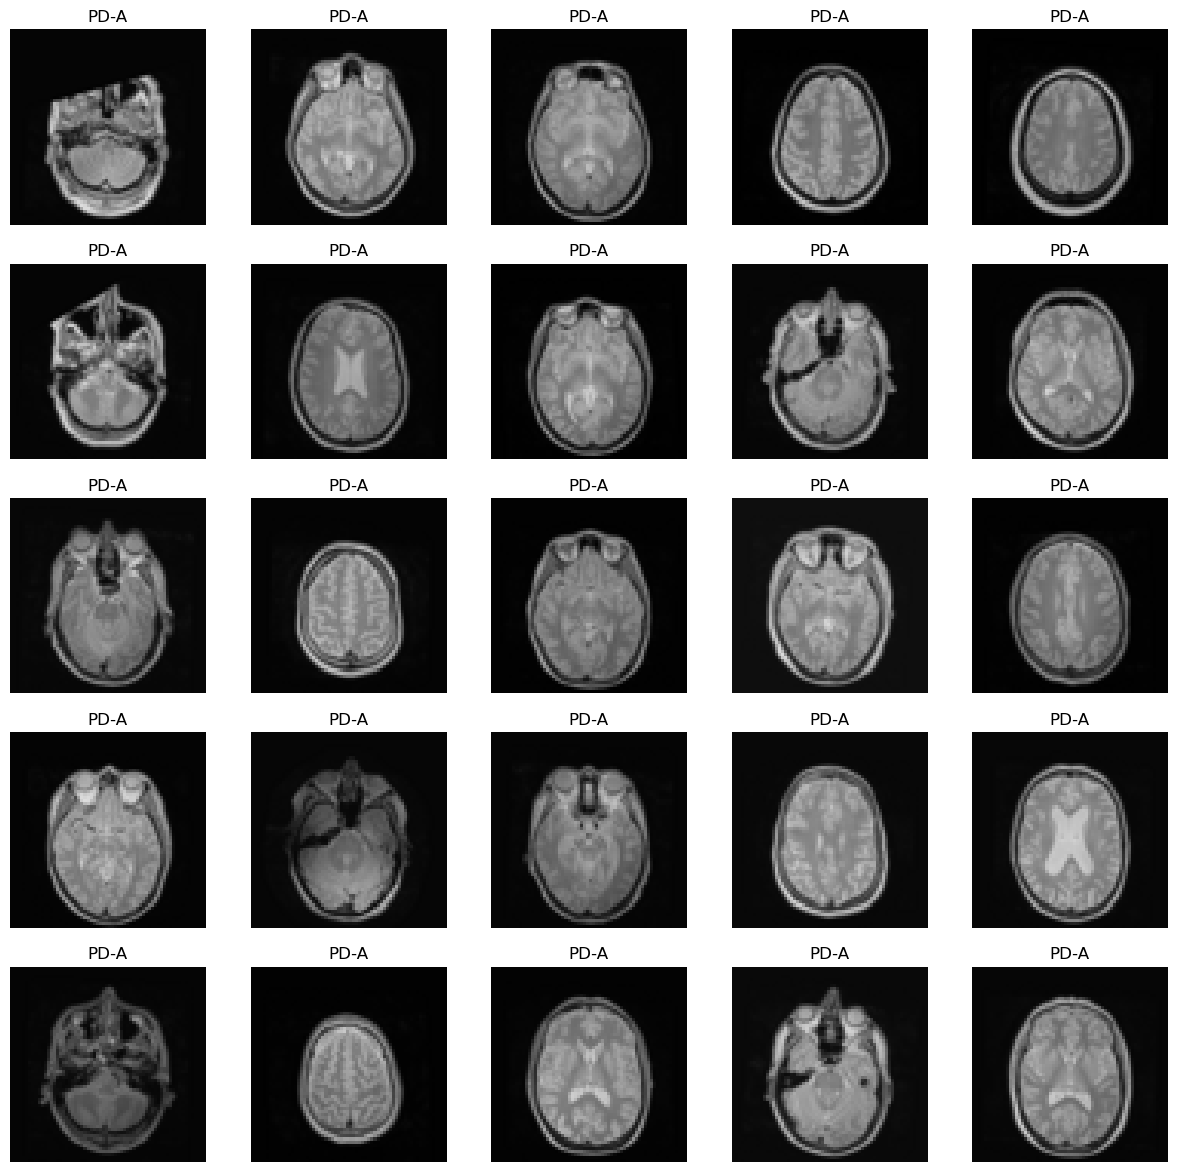

In [13]:
# doing same for test set
test_image_file_list = []
test_label_list = []
           
for i in range(len(class_names)):
    for filename in glob.iglob( os.path.join(input_test_path,class_names[i]) + '/**/*.png', recursive=True):
        # extract patient number and slice
        test_image_file_list.append(filename)
        test_label_list.append( i )            

print(len(test_image_file_list), len(test_label_list))

X_test_rgb = ReadImages(test_image_file_list)
y_test = np.asarray(test_label_list)

print(" Shape : " , X_test_rgb.shape, y_test.shape)
print(" Type  : %s  %s"%(X_test_rgb.dtype, y_test.dtype))
print(" Max   : %d  %d"%(X_test_rgb.max(), y_test.max()))
print(" Min   : %d  %d"%(X_test_rgb.min(), y_test.min()))

nb_x = 5
nb_y = 5
plt.figure(figsize=(15,15*nb_x/nb_y), dpi=100)
for i in range(1, nb_x * nb_y +1):
    plt.subplot(nb_x, nb_y ,i)
    plot_image( X_test_rgb[i-1] )
    plt.title(class_names[y_test[i-1]])
# here we have not shuffle filenames :p

Verify shapes that should look like ( batch_size, desired_height, desired_width, 3 ) and (batch_size, )

### <span style="color:brown"> **B5 - Convert the data shape and type**
The _png_ files are RGB, we convert them to gray images for each set (train, validation and test) in order to be compatible with all tested approaches.

We also divide intensity values by 255 to bound range in [0;1]


 Shape :  (19534, 64, 64, 1) (4884, 64, 64, 1) (6178, 64, 64, 1)
 Type  : float32  float32 float32
 Max   : 1 1 1
 Min   : 0 0 0


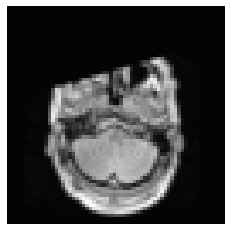

In [14]:
# converting the free data set : rgb to gray scale images, then normalization
X_train = X_train_rgb[:,:,:,1].astype(np.float32)/255
X_train = np.expand_dims(X_train,-1)

X_val = X_val_rgb[:,:,:,1].astype(np.float32)/255
X_val = np.expand_dims(X_val,-1)

X_test = X_test_rgb[:,:,:,1].astype(np.float32)/255
X_test = np.expand_dims(X_test,-1)

print(" Shape : ", X_train.shape, X_val.shape, X_test.shape)
print(" Type  : %s  %s %s"%(X_train.dtype, X_val.dtype, X_test.dtype))
print(" Max   : %d %d %d"%(X_train.max(), X_val.max(), X_test.max()) )
print(" Min   : %d %d %d"%(X_train.min(),X_val.min(), X_test.min()) )
plot_image( X_test[0].squeeze() )

> _**All done, go to the classification step!**_

# <span style="color:brown"> **C - Classification**

### Function for displaying reports

In [15]:
# Usage example : ClassificationReport(model, X_test, y_test, class_names)
def ClassificationReport(model, X_test, y_test, labels_name):  
    # predict 
    print("Prediction on test images")
    predicted = model.predict(X_test)
    y_pred = np.argmax(predicted, axis=-1)
    
    print("Classification report :\n%s\n"
         % (metrics.classification_report(y_test, y_pred)) )
    cm = metrics.confusion_matrix( y_test, y_pred )
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=labels_name)
    disp.plot()
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()

## <span style="color:brown"> **D - CNN Classification**


### <span style="color:brown"> **D2 - Convolutional Neural Network (CNN)**

In order to try to improve the results, we are now looking at convolutional neural networks, of which an example architecture is provided below.

<img src="./figures/architecture_cnn_en.png" alt="Architecture CNN" style="width: 90%"/>


In [16]:
# Definition of variables that you will have to play with during the session to study their influence

# Variables related to the FCN architecture
nb_mlp_neurons = 16    # Number of neurons for one layer
nb_cnn_neurons = 16    # number of feature maps

# Variables related to the optimization process
batch_size  = 16       # Number of images for each batch during the training process 
nb_epochs   = 15       # number of epochs used during the training process
learning_rate = 0.001  # learning rate used during the training process

Run the cell below to create a CNN (Convolutional Neural Network) model using a sequential declaration allowed by the tensorflow library

In [17]:
# This part of the code allows you to free up memory space 
if 'model' in locals(): 
    print("deleting model")
    del model
    
# Define a CNN model from sequential declaration    
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.Conv2D(nb_cnn_neurons//2, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(nb_cnn_neurons, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(nb_cnn_neurons*2, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(nb_mlp_neurons, activation='relu'),  #128
  tf.keras.layers.Dense(num_classes, activation = "softmax")
])

# Display the network structure on the console
model.summary()

2022-07-17 15:52:45.954779: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-17 15:52:45.955722: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-17 15:52:46.012878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 15:52:46.013457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-07-17 15:52:46.013501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-17 15:52:46.015140: I tensorflow/stream_executor/platform/default/dso_loade

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

Run the cell below to train the CNN model

In [18]:
# Compile (define the optimization scheme) the model to be ready for training
from tensorflow.keras import optimizers
from tensorflow import losses

model.compile(
  optimizer=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

# Train the model
model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  batch_size=batch_size,  
  epochs=nb_epochs
)

2022-07-17 15:52:48.851081: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-17 15:52:48.870483: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/15


2022-07-17 15:52:49.401745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-17 15:52:49.645698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-17 15:52:50.887669: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-17 15:52:50.962664: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1221/1221 [==============================] - 21s 10ms/step - loss: 0.6312 - accuracy: 0.7532 - val_loss: 0.1019 - val_accuracy: 0.9652
Epoch 2/15
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0848 - accuracy: 0.9698 - val_loss: 0.1338 - val_accuracy: 0.9498
Epoch 3/15
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0508 - accuracy: 0.9819 - val_loss: 0.0268 - val_accuracy: 0.9912
Epoch 4/15
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 0.0190 - val_accuracy: 0.9957
Epoch 5/15
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.0177 - val_accuracy: 0.9941
Epoch 6/15
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0212 - accuracy: 0.9925 - val_loss: 0.0220 - val_accuracy: 0.9939
Epoch 7/15
1221/1221 [==============================] - 3s 2ms/step - loss: 0.0134 - accuracy: 0.9954 - val_loss: 0.0250 - val_accuracy: 0.9906
E

Run the cell below to evaluate the performance of the model on the test dataset.

In [ ]:
# Compute the overall accuracy of the model on the test dataset 
test_loss, test_accuray = model.evaluate(X_test, y_test, verbose=1)
print('Test accuracy:', test_accuray)

# Compute and display standart classication metrics, i.e. precision, recall, f1-score, support and confusion matrix 
ClassificationReport(model, X_test, y_test, class_names)

## <span style="color:brown"> **E - Why it works so good?**

Can we analyze how the network analyze the images? 

In some way the answer is yes, partially. This is the aim of __explainability__ and __interpretability__.
    
 
The idea is to observe which part of the image influence the final classification decision.
For a given class and a given image, which pixels contributes to activate the last layer?
Many methods have been proposed (GradCAM, intergrated CAM , see the work of Linardatos 2021 https://www.mdpi.com/1099-4300/23/1/18/pdf ).
    
Here we propose to use the GradCam approach to explore which pixels contributes to the final class activation.
    

In [ ]:
def make_gradcam_heatmap(img_array, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Then a function to display the heatmap

In [ ]:
import matplotlib.cm as cm

def display_gradcam(img_array, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img_array = np.uint8(255 * img_array)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_array[0]
    return np.float32(superimposed_img/255)

### <span style="color:brown"> **E2 - Exploring activation maps**
    
Now explore the activation map of a given image and the last convolutional layer output

In [1]:
last_conv_layer_name = 'conv2d_2'    # <----- selected layer (simple network)
img_array = X_test[1:2]               # <----- selected image
print(img_array.shape)

# Remove the last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

print("Predicted outputs:", preds)

NameError: name 'X_test' is not defined

In [ ]:
print("arg max of Predicted:", np.argmax(preds))
index_pred = np.argmax(preds)      # <----- select the index you want to analyse how it has been activated

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, last_conv_layer_name, index_pred )

print(heatmap.shape)

In [ ]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
active_img = display_gradcam(img_array, heatmap)
plt.imshow(active_img, aspect="equal", interpolation="nearest")

### <span style="color:red"> **Questions**
- When index_pred is the arg max of the predictions, where are the pixels that activate this class? What did you expect?
- And when index_pred is not the arg max of the predictions (is such case, the activation means: why the network does not conclude this is this 'wrong' class), where are the pixels that activate this class?    
- Conclusions? Why the network work so well ?
- Can you propose a way to remove this biais from the inputs images?